<a href="https://colab.research.google.com/github/KRHero03/COVID19/blob/master/covid19classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from os import getcwd

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [13]:
print(os.listdir(getcwd()+'/gdrive/My Drive/Colab Notebooks/COVID19/'))

['Untitled0.ipynb', 'CT_COVID.zip', 'CT_NonCOVID.zip']


In [5]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (150, 150,3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
    layer.trainable = False

# pre_trained_model.summary()

--2020-05-12 05:17:26--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.111.128, 2607:f8b0:4001:c1d::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.111.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  53.7MB/s    in 1.6s    

2020-05-12 05:17:28 (53.7 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [0]:
last_layer = pre_trained_model.get_layer('mixed7')
last_output = last_layer.output

In [0]:
'''
Model with transfer learning. Gives training accuracy around 79%-80%
'''
from tensorflow.keras.optimizers import RMSprop

x = layers.Flatten()(last_output)
x = layers.Dense(1024,activation='relu')(x)
x = layers.Dropout(0.2)(x)                
x = layers.Dense(1,activation='sigmoid')(x)       

model = Model(pre_trained_model.input,x) 

model.compile(optimizer = RMSprop(lr=0.01), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

# model.summary()

In [0]:
'''
Model without transfer learning. Gives training accuracy around 70%
'''
model1 = tf.keras.Sequential([
  tf.keras.layers.Conv2D(32,(3,3),activation='relu',input_shape=(150,150,3)),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(32,(3,3),activation='relu',input_shape=(150,150,3)),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(64,(3,3),activation='relu',input_shape=(150,150,3)),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(128,(3,3),activation='relu',input_shape=(150,150,3)),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1024,activation='relu'),
  tf.keras.layers.Dense(1,activation='sigmoid')
])


model1.compile(optimizer = RMSprop(lr=0.001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

In [0]:
positive_data_zip = f"{getcwd()}/gdrive/My Drive/Colab Notebooks/COVID19/CT_COVID.zip"
negative_data_zip = f"{getcwd()}/gdrive/My Drive/Colab Notebooks/COVID19/CT_NonCOVID.zip"
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import zipfile
import shutil

shutil.rmtree('/tmp')
local_zip = positive_data_zip
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/POSITIVE/')
zip_ref.close()

local_zip = negative_data_zip
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/NEGATIVE/')
zip_ref.close()

In [0]:
positive_dir = '/tmp/POSITIVE/CT_COVID/'
negative_dir = '/tmp/NEGATIVE/CT_NonCOVID/'

train_dir = '/tmp/COVID19/training/'
validation_dir = '/tmp/COVID19/validation/'
training_positive_dir = '/tmp/COVID19/training/COVID19/'
training_negative_dir = '/tmp/COVID19/training/NONCOVID19/'
validation_positive_dir = '/tmp/COVID19/validation/COVID19/'
validation_negative_dir = '/tmp/COVID19/validation/NONCOVID19/'

try:
  os.mkdir('/tmp/COVID19/')
  os.mkdir(train_dir)
  os.mkdir(validation_dir)
  os.mkdir(training_positive_dir)
  os.mkdir(training_negative_dir)
  os.mkdir(validation_positive_dir)
  os.mkdir(validation_negative_dir)
except OSError:
  pass

In [16]:
print(len(os.listdir(negative_dir)))
print(len(os.listdir(positive_dir)))

397
349


In [0]:
import random

def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    images = os.listdir(SOURCE)
    shuffled_images = random.sample(images,len(images))
    training_images = shuffled_images[:int(SPLIT_SIZE*len(images))]
    testing_images = shuffled_images[int(SPLIT_SIZE*len(images)):]
    for image in training_images:
        shutil.copyfile(os.path.join(SOURCE,image),os.path.join(TRAINING,image))
    for image in testing_images:
        shutil.copyfile(os.path.join(SOURCE,image),os.path.join(TESTING,image))



split_size = .9
split_data(positive_dir, training_positive_dir, validation_positive_dir, split_size)
split_data(negative_dir, training_negative_dir, validation_negative_dir, split_size)

In [18]:
print(len(os.listdir(training_positive_dir)))
print(len(os.listdir(training_negative_dir)))
print(len(os.listdir(validation_positive_dir)))
print(len(os.listdir(validation_negative_dir)))

314
357
35
40


In [19]:
train_datagen = ImageDataGenerator(
                    rescale=1.0/255.0,
                    rotation_range = 40,
                    width_shift_range = 0.2,
                    height_shift_range = 0.2,
                    shear_range = 0.2,
                    zoom_range = 0.2,
                    fill_mode = 'nearest',
                    horizontal_flip = True
                )

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1.0/255.0)# Your Code Here )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,batch_size = 32, target_size = (150,150), class_mode = 'binary')
# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory(validation_dir,batch_size = 32, target_size = (150,150), class_mode = 'binary')


Found 671 images belonging to 2 classes.
Found 75 images belonging to 2 classes.


In [24]:
history = model1.fit(train_generator,epochs = 20, steps_per_epoch = 32, validation_data=validation_generator,validation_steps = 3)

Epoch 1/20
32/32 [==============================] - 37s 1s/step - loss: 0.8427 - accuracy: 0.4902 - val_loss: 0.8279 - val_accuracy: 0.5733
Epoch 2/20
32/32 [==============================] - 37s 1s/step - loss: 0.6829 - accuracy: 0.5591 - val_loss: 0.7422 - val_accuracy: 0.5333
Epoch 3/20
32/32 [==============================] - 40s 1s/step - loss: 0.6835 - accuracy: 0.5411 - val_loss: 0.7055 - val_accuracy: 0.5067
Epoch 4/20
32/32 [==============================] - 36s 1s/step - loss: 0.6690 - accuracy: 0.5924 - val_loss: 0.7085 - val_accuracy: 0.5467
Epoch 5/20
32/32 [==============================] - 37s 1s/step - loss: 0.6745 - accuracy: 0.5949 - val_loss: 0.7197 - val_accuracy: 0.5467
Epoch 6/20
32/32 [==============================] - 36s 1s/step - loss: 0.6602 - accuracy: 0.5875 - val_loss: 0.7207 - val_accuracy: 0.4667
Epoch 7/20
32/32 [==============================] - 36s 1s/step - loss: 0.6457 - accuracy: 0.6213 - val_loss: 1.3568 - val_accuracy: 0.4400
Epoch 8/20
32/32 [==

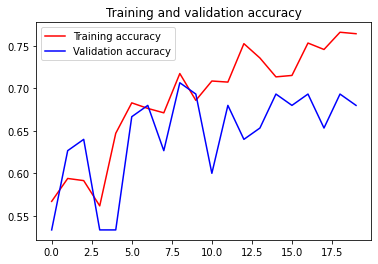

<Figure size 432x288 with 0 Axes>

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

In [0]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150,150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print("POSITIVE")
  else:
    print("NEGATIVE")